In [1]:
import os
import sys
# SRC_DIR environment variable should be the absolute path to the 'multicopy-STR-genotyping' directory
sys.path.append(os.environ["SRC_DIR"])

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from multicopy_STR_genotyping import file_io

sns.set_context("poster")
%matplotlib inline

In [49]:
df_repeats, df_calls = file_io.dfs_from_vcf(
    filename="../../data/banana/variants/SAMEA5752290_NextSeq500.vcf", 
    samples=["SAMEA5752290"], 
    vcf_format="ConSTRain"
)

df_calls = df_calls.dropna().assign(
    depth = lambda x: [sum(i.values()) for i in x["frequencies"]],
    depth_norm = lambda x: x["depth"] / x["copy_number"],
).reset_index(drop=True)

df_calls = df_calls.merge(df_repeats[["str_id", "chr", "start", "end", "period"]], on="str_id")

df_repeats.shape, df_calls.shape

((183345, 7), (153645, 11))

In [50]:
df_repeats.head()

,str_id,chr,start,end,unit,period,ref
0,chr01_22744,chr01,22744,22755,CCCT,4,3
1,chr01_33907,chr01,33907,33924,CCTTTG,6,3
2,chr01_35392,chr01,35392,35417,AT,2,13
3,chr01_35829,chr01,35829,35842,AT,2,7
4,chr01_37881,chr01,37881,37930,AT,2,25


In [52]:
df_calls.head()

,sample,str_id,copy_number,frequencies,genotype,depth,depth_norm,chr,start,end,period
0,SAMEA5752290,chr01_22744,3,{3: 12},"[3, 3, 3]",12,4.000000,chr01,22744,22755,4
1,SAMEA5752290,chr01_33907,3,{3: 26},"[3, 3, 3]",26,8.666667,chr01,33907,33924,6
2,SAMEA5752290,chr01_35829,3,"{5: 6, 6: 4}","[5, 5, 6]",10,3.333333,chr01,35829,35842,2
3,SAMEA5752290,chr01_37881,3,{18: 2},"[18, 18, 18]",2,0.666667,chr01,37881,37930,2
4,SAMEA5752290,chr01_37997,3,{7: 4},"[7, 7, 7]",4,1.333333,chr01,37997,38046,2


In [171]:
df_calls.query("depth_norm >= 100").shape

(59, 12)

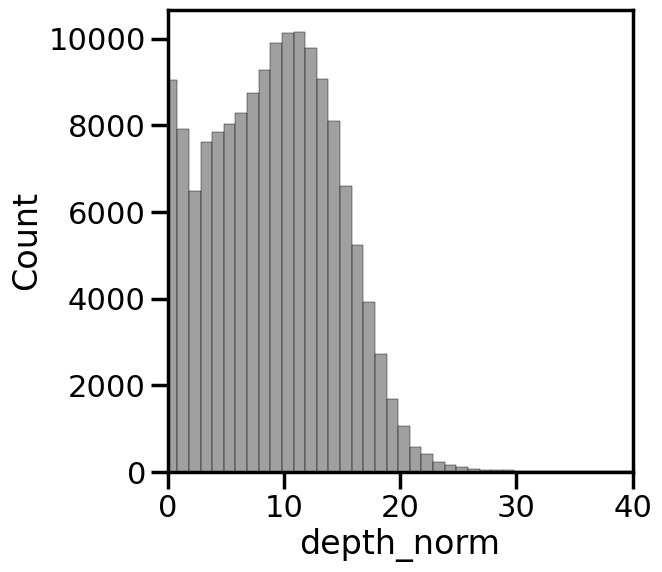

In [172]:
fig = plt.figure(figsize=(6, 6))

ax = sns.histplot(
    df_calls.query("depth_norm < 100"),
    x="depth_norm",
    discrete=True,
    color="grey"
)

_ = ax.set(
    xlim=(0, 40)
)

In [150]:
depth_filter = 0.05

print(df_calls.shape)
lower = max(df_calls.query("period > 1")["depth_norm"].quantile(q=depth_filter/2), 1.) # need at least 3 reads for triploid organism
upper = df_calls.query("period > 1")["depth_norm"].quantile(q=1-(depth_filter/2))
print(lower, upper)
df_calls_filt = df_calls.query(f"depth_norm >= {lower} and depth_norm <= {upper}").reset_index(drop=True)
print(df_calls_filt.shape)

(153645, 12)
1.0 19.0
(140418, 12)


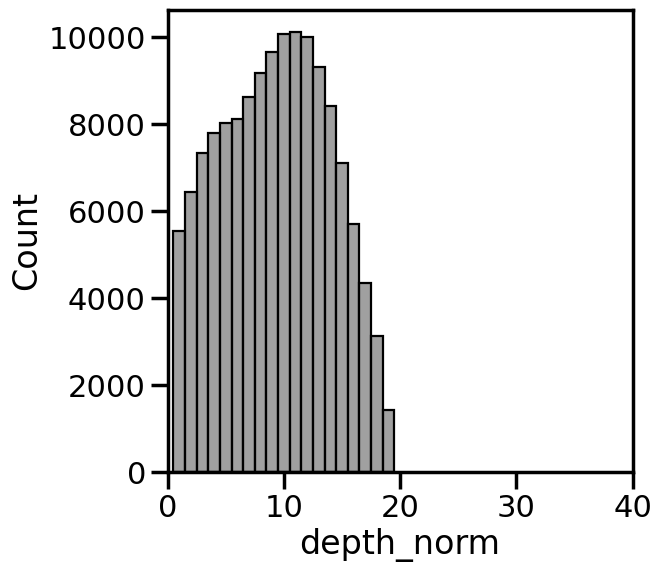

In [173]:
fig = plt.figure(figsize=(6, 6))

ax = sns.histplot(
    df_calls_filt,
    x="depth_norm",
    discrete=True,
    color="grey"
)

_ = ax.set(
    xlim=(0, 40)
)

In [178]:
df_calls.query("chr == 'chr02'")["depth_norm"].mean()

9.944994499449944

In [108]:
print(df_calls["depth_norm"].mean())

start, end = 28000000, 32000000
print(df_calls.query(f"chr == 'chr02' and start > {start} and end < {end}")["depth_norm"].shape)
df_calls.query(f"chr == 'chr02' and start > {start} and end < {end}")["depth_norm"].mean()

9.406577933982016
(1790,)


14.06294227188082

In [124]:
df_calls = df_calls.assign(in_dup = lambda x: np.array((x["chr"] == "chr02") & (x["start"] > start) & (x["end"] < end)))
df_calls

,sample,str_id,copy_number,frequencies,genotype,depth,depth_norm,chr,start,end,period,in_dup
0,SAMEA5752290,chr01_22744,3,{3: 12},"[3, 3, 3]",12,4.000000,chr01,22744,22755,4,False
1,SAMEA5752290,chr01_33907,3,{3: 26},"[3, 3, 3]",26,8.666667,chr01,33907,33924,6,False
2,SAMEA5752290,chr01_35829,3,"{5: 6, 6: 4}","[5, 5, 6]",10,3.333333,chr01,35829,35842,2,False
3,SAMEA5752290,chr01_37881,3,{18: 2},"[18, 18, 18]",2,0.666667,chr01,37881,37930,2,False
4,SAMEA5752290,chr01_37997,3,{7: 4},"[7, 7, 7]",4,1.333333,chr01,37997,38046,2,False
...,...,...,...,...,...,...,...,...,...,...,...,...
153640,SAMEA5752290,chr11_34616355,3,{2: 3},"[2, 2, 2]",3,1.000000,chr11,34616355,34616372,6,False
153641,SAMEA5752290,chr11_34619648,3,{3: 4},"[3, 3, 3]",4,1.333333,chr11,34619648,34619662,5,False
153642,SAMEA5752290,chr11_34628454,3,{3: 1},"[3, 3, 3]",1,0.333333,chr11,34628454,34628468,5,False
153643,SAMEA5752290,chr11_34629565,3,{2: 1},"[2, 2, 2]",1,0.333333,chr11,34629565,34629582,6,False


In [138]:
(df_calls
     .assign(in_range = lambda x: np.array((x["depth_norm"] >= lower) & (x["depth_norm"] < upper)))
     .groupby("in_dup", as_index=False)
     .value_counts(["in_range"], normalize=True)
)



,in_dup,in_range,proportion
0,False,True,0.911725
1,False,False,0.088275
2,True,True,0.744134
3,True,False,0.255866


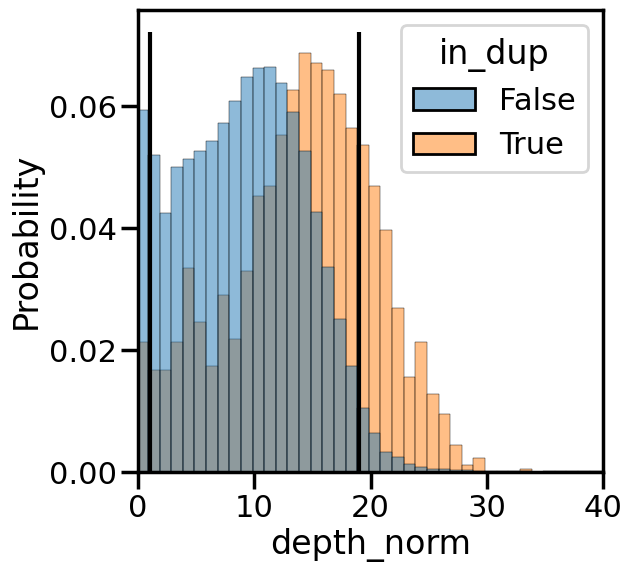

In [175]:
fig = plt.figure(figsize=(6, 6))

ax = sns.histplot(
    df_calls.query("depth_norm < 100").assign(in_dup = lambda x: np.array((x["chr"] == "chr02") & (x["start"] > start) & (x["end"] < end))),
    x="depth_norm",
    hue="in_dup",
    discrete=True,
    stat="probability",
    common_norm=False
)

ax.vlines(x=[lower, upper], ymin=0, ymax=ax.get_ylim()[1], color="black")

_ = ax.set(
    xlim=(0, 40)
)

plt.show()

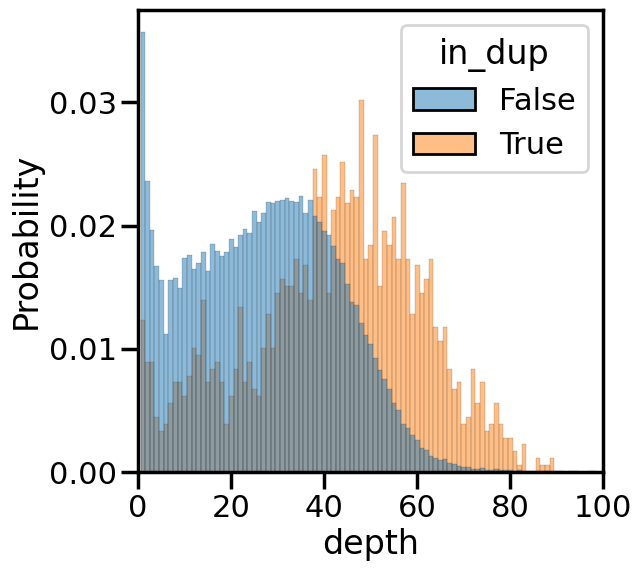

In [176]:
fig = plt.figure(figsize=(6, 6))

ax = sns.histplot(
    df_calls.query("depth_norm < 100").assign(in_dup = lambda x: np.array((x["chr"] == "chr02") & (x["start"] > start) & (x["end"] < end))),
    x="depth",
    hue="in_dup",
    discrete=True,
    stat="probability",
    common_norm=False
)

_ = ax.set(
    xlim=(0, 100)
)

In [140]:
(df_calls
     .assign(
         depth_norm = lambda x: [i * .75 if j else i for i, j in zip(x["depth_norm"], x["in_dup"])],
         in_range = lambda x: np.array((x["depth_norm"] >= lower) & (x["depth_norm"] < upper))
     )
     .groupby("in_dup", as_index=False)
     .value_counts(["in_range"], normalize=True)
)

,in_dup,in_range,proportion
0,False,True,0.911725
1,False,False,0.088275
2,True,True,0.942458
3,True,False,0.057542


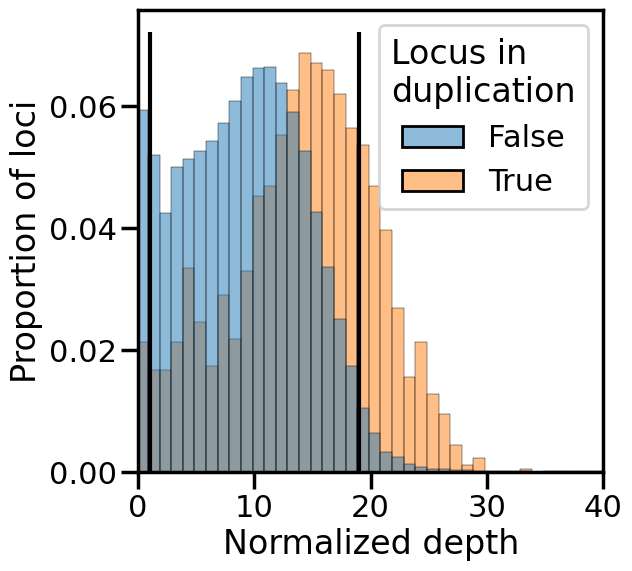

In [161]:
fig = plt.figure(figsize=(6, 6))

ax = sns.histplot(
    df_calls.query("depth_norm <= 100"),
    x="depth_norm",
    hue="in_dup",
    discrete=True,
    stat="probability",
    common_norm=False
)

ax.vlines(x=[lower, upper], ymin=0, ymax=ax.get_ylim()[1], color="black")

_ = ax.set(
    xlim=(0, 40),
    xlabel="Normalized depth",
    ylabel="Proportion of loci"
)

_ = ax.get_legend().set(title="Locus in\nduplication")

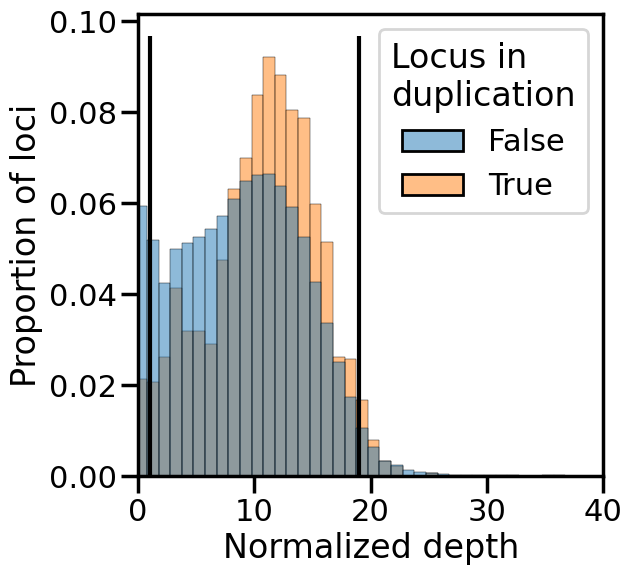

In [162]:
fig = plt.figure(figsize=(6, 6))

ax = sns.histplot(
    df_calls.query("depth_norm < 100").assign(depth_norm = lambda x: [i * .75 if j else i for i, j in zip(x["depth_norm"], x["in_dup"])]),
    x="depth_norm",
    hue="in_dup",
    discrete=True,
    stat="probability",
    common_norm=False
)

ax.vlines(x=[lower, upper], ymin=0, ymax=ax.get_ylim()[1], color="black")

_ = ax.set(
    xlim=(0, 40),
    xlabel="Normalized depth",
    ylabel="Proportion of loci"
)

_ = ax.get_legend().set(title="Locus in\nduplication")

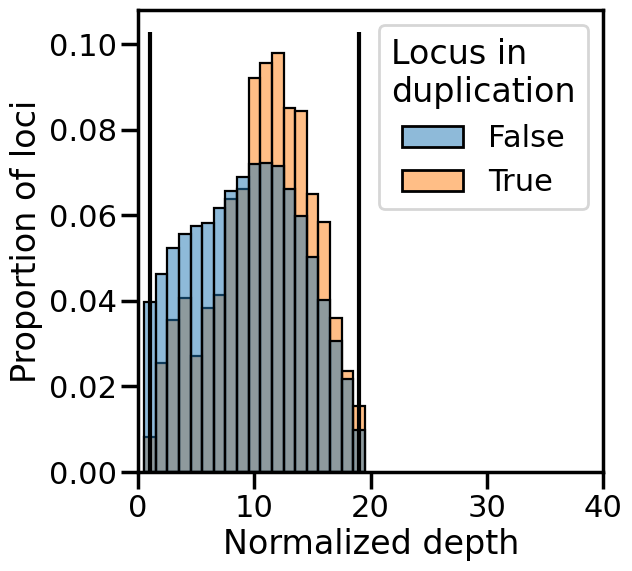

In [177]:
fig = plt.figure(figsize=(6, 6))

ax = sns.histplot(
    df_calls.assign(
        depth_norm = lambda x: [i * .75 if j else i for i, j in zip(x["depth_norm"], x["in_dup"])],
    ).query(f"depth_norm >= {lower} and depth_norm <= {upper}"),
    x="depth_norm",
    hue="in_dup",
    discrete=True,
    stat="probability",
    common_norm=False
)

ax.vlines(x=[lower, upper], ymin=0, ymax=ax.get_ylim()[1], color="black")

_ = ax.set(
    xlim=(0, 40),
    xlabel="Normalized depth",
    ylabel="Proportion of loci"
)

_ = ax.get_legend().set(title="Locus in\nduplication")